# Random forest for binary classification

The first model we'll train is a simple random forest model.\
We'll perform binary classification on Y (with the threshold at Y = 50), and we'll use the following variables:

- PCA1 and PCA2 (PCA projection of X4, X5 and X6)
- X2_X3_encoding (categorical encoding of all unique X2 X3 sequence pairs)
- weighting the minority class (Y < 50) 3 times as much as the majority class (Y > 50) - roughly the relative frequency of the classes

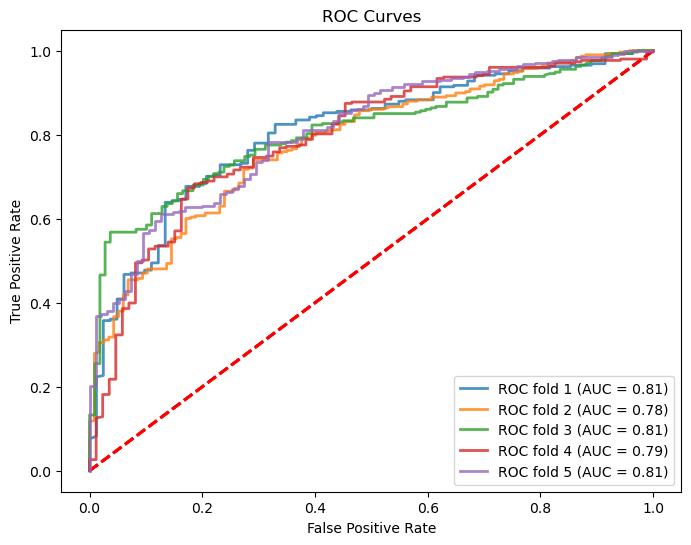

accuracy: 
 0.7438421201950861

precision: 
 0.875702442418198

recall: 
 0.7693732440505918

f1: 
 0.8183524007601329

auc: 
 0.7998762355980708

confusion_matrix: 
 [[0.67241379 0.32758621]
 [0.23062676 0.76937324]]



In [91]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Load the data
data = pd.read_json("preprocessed_data.json")

# Separate the features and labels
rf_y = data["Y_binary"]*1
rf_X = data[["PCA1", "PCA2", "X2_X3_encoding"]]

# One-hot encode X2_X3_encoding column
rf_X = pd.get_dummies(rf_X, columns=["X2_X3_encoding"])

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]

# Initialize a dictionary to store the metrics for each fold
metrics_dict = {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [], "confusion_matrix": []}

# Perform cross-validation
plt.figure(figsize=(8, 6))

for i in range(5):
    # Split the data into training and testing sets for this fold
    X_train = rf_X.loc[~fold_indices[i], :]
    X_test = rf_X.loc[fold_indices[i], :]
    y_train = rf_y.loc[~fold_indices[i]]
    y_test = rf_y.loc[fold_indices[i]]

    # Train a random forest classifier on the training data for this fold
    clf = RandomForestClassifier(n_estimators=100,
                                 max_depth=10,
                                 random_state=0,
                                 class_weight={0:3, 1:1})
                              
    clf.fit(X_train, y_train)

    # Predict the labels for the testing data and calculate the metrics for this fold
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred, normalize="true")

    # Store the metrics for this fold in the dictionary
    metrics_dict["accuracy"].append(accuracy)
    metrics_dict["precision"].append(precision)
    metrics_dict["recall"].append(recall)
    metrics_dict["f1"].append(f1)
    metrics_dict["auc"].append(roc_auc)
    metrics_dict["confusion_matrix"].append(cm)

    # Plot the ROC curve for this fold
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=.8)
    plt.plot(fpr, tpr, lw=2, alpha=0.8, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")

# Show all the ROC curves
plt.title(f"ROC Curves")
plt.show()

# Print the metrics
for metric in ["accuracy", "precision", "recall", "f1", "auc", "confusion_matrix"]:
    print(f"{metric}: \n {sum(metrics_dict[metric])/5}\n")

The results seems to be quite satisfying for such a simple model. \
There is a small bias towards classifying the samples as Y > 50, and the true positive rate is also ~10% higher than the true negative rate.

# Simple neural network for classification

The next model we'll train is a simple neural network model.\
We'll perform binary classification on Y (with the threshold at Y = 50), and we'll use the following variables:

- PCA1 and PCA2 (PCA projection of X4, X5 and X6)
- X2_X3_encoding (categorical encoding of all unique X2 X3 sequence pairs)
- weighting the minority class (Y < 50) 3 times as much as the majority class (Y > 50) - roughly the relative frequency of the classes

In [325]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

    
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.droput = nn.Dropout(p=.25)
        

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = self.droput(x)
        x = self.fc4(x)
        return x
    
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

training fold 0


100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


evaluation fold 0
accuracy: 0.6997319034852547
precision: 0.8977777777777778
recall: 0.6941580756013745
training fold 1


100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


evaluation fold 1
accuracy: 0.7082352941176471
precision: 0.868
recall: 0.7045454545454546
training fold 2


100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


evaluation fold 2
accuracy: 0.7270471464019851
precision: 0.8801652892561983
recall: 0.7244897959183674
training fold 3


100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


evaluation fold 3
accuracy: 0.7017994858611826
precision: 0.9230769230769231
recall: 0.6732673267326733
training fold 4


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


evaluation fold 4
accuracy: 0.6819407008086253
precision: 0.8691588785046729
recall: 0.6739130434782609


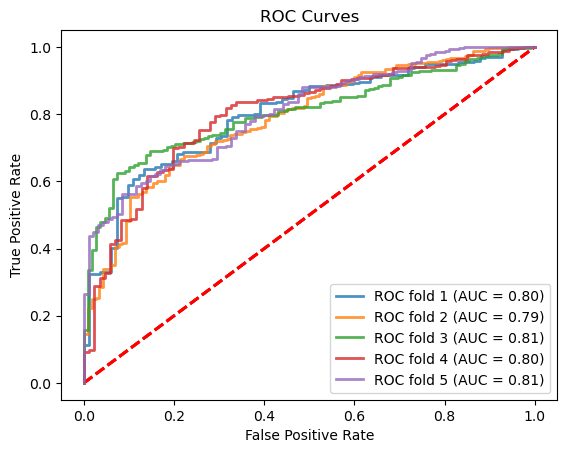

accuracy: 
 0.703750906134939

precision: 
 0.8876357737231144

recall: 
 0.6940747392552262

f1: 
 0.7786618522565465

auc: 
 0.8009327294240632

confusion_matrix: 
 [[0.73579892 0.26420108]
 [0.30592526 0.69407474]]



In [340]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_json("preprocessed_data.json")

# Separate the features and labels
nn_y = data["Y"]

nn_y = (nn_y > 50).astype(int)

nn_X = data[["PCA1", "PCA2", "X2_X3_encoding"]]

# One-hot encode X2_X3_encoding column
nn_X = pd.get_dummies(nn_X, columns=["X2_X3_encoding"])

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]

# Initialize a dictionary to store the metrics for each fold
metrics_dict = {"mse": [], "L1": []}

# Define the hyperparameters
learning_rate = 1e-4
n_epochs = 100
batch_size = 32

metrics_dict = {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": [], "confusion_matrix": []}

# Perform cross-validation
for i in range(5):

    # Split the data into training and testing sets for this fold
    X_train = nn_X.loc[~fold_indices[i], :]
    X_test = nn_X.loc[fold_indices[i], :]
    y_train = nn_y.loc[~fold_indices[i]]
    y_test = nn_y.loc[fold_indices[i]]

    # Create PyTorch datasets and data loaders
    train_dataset = MyDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = MyDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    # Initialize the neural network and optimizer
    net = SimpleNet()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Train the neural network
    print(f"training fold {i}")
    net.train()
    for epoch in tqdm(range(n_epochs)):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = net(X_batch)
            weights = (y_batch-1).abs()*2 + 1
            loss = nn.BCEWithLogitsLoss(weight=weights)(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    
    #Evaluate the neural network on the testing data for this fold
    print(f"evaluation fold {i}")
    net.eval()
    with torch.no_grad():
        for X_batch, y_test in test_loader:
            y_pred_proba = net(X_batch)
            y_pred = nn.Sigmoid()(y_pred_proba)
            y_pred = (y_pred >= 0.5)


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred, normalize="true")

    # Store the metrics for this fold in the dictionary
    metrics_dict["accuracy"].append(accuracy)
    metrics_dict["precision"].append(precision)
    metrics_dict["recall"].append(recall)
    metrics_dict["f1"].append(f1)
    metrics_dict["auc"].append(roc_auc)
    metrics_dict["confusion_matrix"].append(cm)

    for key in ["accuracy", "precision", "recall"]:
        print(f"{key}: {metrics_dict[key][-1]}")

    # Plot the ROC curve for this fold
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=.8)
    plt.plot(fpr, tpr, lw=2, alpha=0.8, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")

# Show all the ROC curves
plt.title(f"ROC Curves")
plt.show()

# Print the metrics
for metric in ["accuracy", "precision", "recall", "f1", "auc", "confusion_matrix"]:
    print(f"{metric}: \n {sum(metrics_dict[metric])/5}\n")

The results from this model is quite similar to the ones we got from the random forest model.
* The accuracy is 4 % lower
* The precision is 1 % higher
* The recall is 10 % lower
* The f1 score is 3 % lower
* The true negative rate is 7 % higher
* The true postivie rate is 8 % lower

All in all the choice between these two models in their current form depends on the relative importance between false positives and false negatives for the usecase of the data.

# Simple neural network for regression
The next model will be a simple feed forward neural network using the following variables

- PCA1 and PCA2 (PCA projection of X4, X5 and X6)
- X2_X3_encoding (categorical encoding of all unique X2 X3 sequence pairs)
- weighting the minority class (Y < 50) 3 times as much as the majority class (Y > 50) - roughly the relative frequency of the classes

I will use it to predict the log transformed Y values

In [239]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define the neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.droput = nn.Dropout(p=.3)
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #x = (nn.Tanh()(x)+1)*10
        #x = self.droput(x)
        return x

# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [241]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_json("preprocessed_data.json")

# Separate the features and labels
nn_y = data["log(Y+1)"]
nn_X = data[["PCA1", "PCA2", "X2_X3_encoding"]]

# One-hot encode X2_X3_encoding column
nn_X = pd.get_dummies(nn_X, columns=["X2_X3_encoding"])

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]

# Initialize a dictionary to store the metrics for each fold
metrics_dict = {"mse": [], "L1": []}

# Define the hyperparameters
learning_rate = 1e-3
n_epochs = 500
batch_size = 32

# Perform cross-validation
for i in range(1):
    # Split the data into training and testing sets for this fold
    X_train = nn_X.loc[~fold_indices[i], :]
    X_test = nn_X.loc[fold_indices[i], :]
    y_train = nn_y.loc[~fold_indices[i]]
    y_test = nn_y.loc[fold_indices[i]]

    # Create PyTorch datasets and data loaders
    train_dataset = MyDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = MyDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the neural network and optimizer
    net = SimpleNet()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Train the neural network
    print(f"training fold {i}")
    net.train()
    for epoch in range(n_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = net(X_batch)
            loss = nn.MSELoss()(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        print(f"loss: {loss.item()}")
    
    # Evaluate the neural network on the testing data for this fold
    net.eval()
    test_MSE = test_L1 = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = net(X_batch)
            test_L1 += nn.L1Loss()(y_pred, y_batch).item()
            test_MSE += nn.MSELoss()(y_pred, y_batch).item()
    mse = test_MSE / len(test_loader)
    L1 = test_L1 / len(test_loader)
    
    # Save the MSE for this fold
    metrics_dict["mse"].append(mse)
    metrics_dict["L1"].append(L1)

# Print the mean and standard deviation of the MSE across all folds
mse_mean = np.mean(metrics_dict["mse"])
mse_std = np.std(metrics_dict["mse"])
print("Mean MSE: {:.4f}, Std. Dev. of MSE: {:.4f}".format(mse_mean, mse_std))

training fold 0
loss: 25.140501022338867
loss: 16.51902198791504
loss: 8.251860618591309
loss: 7.110593318939209
loss: 6.541633605957031
loss: 6.17044734954834
loss: 5.914200782775879
loss: 5.729876518249512
loss: 5.594002723693848
loss: 5.495068073272705
loss: 5.415717601776123
loss: 5.352551460266113
loss: 5.302042484283447
loss: 5.264485836029053
loss: 5.233712196350098
loss: 5.2101287841796875
loss: 5.188565254211426
loss: 5.170570373535156
loss: 5.156416893005371
loss: 5.144078254699707
loss: 5.134134769439697
loss: 5.128951549530029
loss: 5.120655536651611
loss: 5.1128082275390625
loss: 5.107821941375732
loss: 5.1032562255859375
loss: 5.098456382751465
loss: 5.094818592071533
loss: 5.090063571929932
loss: 5.087782382965088
loss: 5.0822553634643555
loss: 5.080695152282715
loss: 5.081236839294434
loss: 5.080592632293701
loss: 5.079883575439453
loss: 5.083930015563965
loss: 5.085053443908691
loss: 5.085297584533691
loss: 5.086090087890625
loss: 5.0905680656433105
loss: 5.09658432006

# Fancy neural network for regression

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads):
        super().__init__()
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim), 
            num_layers=num_layers
        )
        self.output_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.output_layer(x)
        return x

# Example usage:
input_dim = 13
output_dim = 1
hidden_dim = 64
num_layers = 2
num_heads = 1

model = TransformerRegressor(input_dim, output_dim, hidden_dim, num_layers, num_heads)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Generate some sample data
x = np.random.randn(100, input_dim).astype(np.float32)
y = np.random.randn(100, output_dim).astype(np.float32)

# Train the model
for epoch in range(100):
    optimizer.zero_grad()
    output = model(torch.from_numpy(x))
    loss = criterion(output, torch.from_numpy(y))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

In [419]:
x.shape

(100, 13)

In [413]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Define the neural network
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads):
        super().__init__()
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim), 
            num_layers=num_layers
        )
        self.output_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.output_layer(x)
        return x

# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.pca = torch.tensor(X[["PCA1", "PCA2"]].values, dtype=torch.float32)
        self.X2_vec = torch.stack([torch.tensor(sample[0]) for sample in X["X2_vec"]])
        self.X3_vec = torch.stack([torch.tensor(sample[0]) for sample in X["X3_vec"]])
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.pca[idx], self.X2_vec[idx], self.X3_vec[idx], self.y

In [414]:
# Load the data
data = pd.read_json("preprocessed_data.json")

# Separate the features and labels
nn_y = data["log(Y+1)"]
nn_X = data[["PCA1", "PCA2", "X2_vec", "X3_vec"]]

# Initialize a dictionary to store the metrics for each fold
metrics_dict = {"mse": [], "L1": []}

# Define the hyperparameters
learning_rate = 1e-3
n_epochs = 500
batch_size = 32

output_dim = 1
hidden_dim = 512
num_layers = 2
num_heads = 4

# Perform cross-validation
for i in range(1):
    # Split the data into training and testing sets for this fold
    X_train = nn_X.loc[~fold_indices[i], :]
    X_test = nn_X.loc[fold_indices[i], :]
    y_train = nn_y.loc[~fold_indices[i]]
    y_test = nn_y.loc[fold_indices[i]]

    # Create PyTorch datasets and data loaders
    train_dataset = MyDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = MyDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the neural network and optimizer
    net = FancyNetwork(input_dim=2048, output_dim=1, hidden_dim=hidden_dim, num_layers=num_layers, num_heads=num_heads, dropout=0.2)
#     break
#     optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#     # Train the neural network
#     print(f"training fold {i}")
#     net.train()
#     for epoch in range(n_epochs):
#         for X_batch, y_batch in train_loader:
#             optimizer.zero_grad()
#             y_pred = net(X_batch)
#             loss = nn.MSELoss()(y_pred, y_batch)
#             loss.backward()
#             optimizer.step()
#         print(f"loss: {loss.item()}")
    
#     # Evaluate the neural network on the testing data for this fold
#     net.eval()
#     test_MSE = test_L1 = 0.0
#     with torch.no_grad():
#         for X_batch, y_batch in test_loader:
#             y_pred = net(X_batch)
#             test_L1 += nn.L1Loss()(y_pred, y_batch).item()
#             test_MSE += nn.MSELoss()(y_pred, y_batch).item()
#     mse = test_MSE / len(test_loader)
#     L1 = test_L1 / len(test_loader)
    
#     # Save the MSE for this fold
#     metrics_dict["mse"].append(mse)
#     metrics_dict["L1"].append(L1)

# # Print the mean and standard deviation of the MSE across all folds
# mse_mean = np.mean(metrics_dict["mse"])
# mse_std = np.std(metrics_dict["mse"])
# print("Mean MSE: {:.4f}, Std. Dev. of MSE: {:.4f}".format(mse_mean, mse_std))

In [415]:
pca.shape

torch.Size([2])

In [424]:
torch.concatenate([pca,vec2,vec3]).shape

torch.Size([2050])

In [425]:
2050

205.0

In [416]:
pca, vec2, vec3, y = test_dataset[0]

In [407]:
vec2[None].shape

torch.Size([1, 1024])

In [417]:
net(pca,vec2.unsqueeze(1),vec3)

TypeError: unsqueeze() missing 1 required positional arguments: "dim"

In [345]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
data = pd.read_json("preprocessed_data.json")

# Separate the features and labels
nn_y = data["log(Y+1)"]
nn_X = data[["PCA1", "PCA2", "X2_X3_encoding"]]

# One-hot encode X2_X3_encoding column
nn_X = pd.get_dummies(nn_X, columns=["X2_X3_encoding"])

# Use "fold" column for specifying the cross-validation splits
fold_indices = [data["fold"].values == i for i in range(5)]

# Initialize a dictionary to store the metrics for each fold
metrics_dict = {"mse": [], "L1": []}

# Define the hyperparameters
learning_rate = 1e-3
n_epochs = 500
batch_size = 32

input_dim = 13
output_dim = 1
hidden_dim = 64
num_layers = 2
num_heads = 1

# Perform cross-validation
for i in range(1):
    # Split the data into training and testing sets for this fold
    X_train = nn_X.loc[~fold_indices[i], :]
    X_test = nn_X.loc[fold_indices[i], :]
    y_train = nn_y.loc[~fold_indices[i]]
    y_test = nn_y.loc[fold_indices[i]]

    # Create PyTorch datasets and data loaders
    train_dataset = MyDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = MyDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the neural network and optimizer
    net = TransformerRegressor(input_dim, output_dim, hidden_dim, num_layers, num_heads)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Train the neural network
    print(f"training fold {i}")
    net.train()
    for epoch in range(n_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = net(X_batch)
            loss = nn.MSELoss()(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        print(f"loss: {loss.item()}")
    
    # Evaluate the neural network on the testing data for this fold
    net.eval()
    test_MSE = test_L1 = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = net(X_batch)
            test_L1 += nn.L1Loss()(y_pred, y_batch).item()
            test_MSE += nn.MSELoss()(y_pred, y_batch).item()
    mse = test_MSE / len(test_loader)
    L1 = test_L1 / len(test_loader)
    
    # Save the MSE for this fold
    metrics_dict["mse"].append(mse)
    metrics_dict["L1"].append(L1)

# Print the mean and standard deviation of the MSE across all folds
mse_mean = np.mean(metrics_dict["mse"])
mse_std = np.std(metrics_dict["mse"])
print("Mean MSE: {:.4f}, Std. Dev. of MSE: {:.4f}".format(mse_mean, mse_std))

training fold 0
loss: 12.55775260925293
loss: 8.652181625366211
loss: 7.922431945800781
loss: 8.132026672363281
loss: 9.014066696166992
loss: 9.637696266174316
loss: 9.420379638671875
loss: 7.445807456970215
loss: 6.129942893981934
loss: 6.708856105804443
loss: 6.353991508483887
loss: 6.1250224113464355
loss: 6.582855224609375
loss: 5.908179759979248
loss: 5.318656921386719
loss: 6.045040607452393
loss: 6.298598289489746
loss: 5.405845642089844
loss: 5.120733737945557
loss: 5.380465030670166
loss: 5.1685614585876465
loss: 5.045268535614014
loss: 5.181380271911621
loss: 5.181023597717285
loss: 5.37009334564209
loss: 5.189408302307129
loss: 5.5549821853637695
loss: 4.982302665710449
loss: 5.1486992835998535
loss: 5.313360214233398
loss: 5.091195583343506
loss: 4.866115570068359
loss: 5.2726826667785645
loss: 5.037843704223633
loss: 4.745305061340332
loss: 5.228869438171387
loss: 4.872602462768555
loss: 4.9673662185668945
loss: 5.205674648284912
loss: 4.932794570922852
loss: 5.08773326873

KeyboardInterrupt: 

In [426]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.pca = torch.tensor(X[["PCA1", "PCA2"]].values, dtype=torch.float32)
        self.X2_vec = torch.stack([torch.tensor(sample[0]) for sample in X["X2_vec"]])
        self.X3_vec = torch.stack([torch.tensor(sample[0]) for sample in X["X3_vec"]])
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        input_vec = torch.cat([self.pca[idx], self.X2_vec[idx], self.X3_vec[idx]])
        return input_vec, self.y[idx]


In [435]:
2050/5

410.0

In [432]:
# Define the neural network

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, num_heads):
        super().__init__()
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim), 
            num_layers=num_layers
        )
        self.output_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.output_layer(x)
        return x

torch.Size([2050])

In [436]:
# Define the hyperparameters
input_dim = 2050  # 2 from PCA + 2 from X2_vec or X3_vec
output_dim = 1
hidden_dim = 256
num_layers = 2
num_heads = 5
lr = 0.001
batch_size = 32
num_epochs = 10

# Load the data
data = pd.read_json("preprocessed_data.json")

# Separate the features and labels
nn_y = data["log(Y+1)"]
nn_X = data[["PCA1", "PCA2", "X2_vec", "X3_vec"]]

# Initialize a dictionary to store the metrics for each fold
metrics_dict = {"mse": [], "L1": []}

# Load the data
train_data = MyDataset(nn_X, nn_y)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = TransformerRegressor(input_dim, output_dim, hidden_dim, num_layers, num_heads)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_data)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")


Epoch 1 loss: 20.9170
Epoch 2 loss: 9.9071
Epoch 3 loss: 9.8914
Epoch 4 loss: 9.9352
Epoch 5 loss: 9.7256
Epoch 6 loss: 9.8252
Epoch 7 loss: 9.8368
Epoch 8 loss: 10.1157
Epoch 9 loss: 9.7611
Epoch 10 loss: 9.8023
